## Kinematic Bicycle Model

PID parameter tunning depends on the characteristics of system. And it is known that there's no 'one-size-fit-all' tunning method. For the project, i decided to go for a model-based auto-tunning using our python script of kinematic bicycle model, and modified it to write the auto-tunning script. 

In [2]:

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        # theta = w = tan(delta) * speed / L
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)
    


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot

# run - does a single control run
# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

## Goordinate Ascent auto-tunning

Coordinate ascent is an optimization technique where each dimension is maximized(exact or inexactly), with other dimensions fixed. The local search method can be used with or without gradients but its performance heavily depends on initialization. 
So, i first decided a promising initial values of p-gain with trials and then optimized it using CA with d-,i-gain fixed 0. Once the p-gain was optimized, i fixed the p-gain and run CA again to optimize d-gain with i-gain fixed 0. And once d-gain was optimized, i fixed the d-gain and run CA again to optimize i-gain. After each gain was optimized, i ran CA again altogether with the 3 fixed values. For each gain, i set the CA tolerance value to be sufficiently small enough(.002) to make sure that it converges enough to a local minima.

Iter 0, berror = 0.9528339624696167, params=[0.19, 0, 0]
Iter 1, berror = 0.9528339624695925, params=[0.18999999999999995, 0, 0]
Iter 2, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 3, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 4, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 5, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 6, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 7, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 8, berror = 0.9528339624690088, params=[0.18999999999999984, 0.0, 0.0]
Iter 9, berror = 0.9528339624688492, params=[0.18999999999999978, 0.0, 0.0]
Iter 10, berror = 0.9528339624688492, params=[0.18999999999999972, 0.0, 0.0]
Iter 11, berror = 0.9528339624688492, params=[0.18999999999999972, 0.0, 0.0]
Iter 12, berror = 0.9528339624688492, params=[0.18999999999999972, 0.0, 0.0]
Iter 13, berror = 0.952833962468

Iter 55, berror = 0.04212772874671467, params=[0.18999999999999978, 0.27828999999999976, 0.0020136783222407494]
Iter 56, berror = 0.04212772874671467, params=[0.18999999999999978, 0.27828999999999976, 0.0020136783222407485]
Iter 57, berror = 0.04212772874671467, params=[0.18999999999999978, 0.27828999999999976, 0.0020136783222407485]
Iter 58, berror = 0.0334417047494199, params=[0.18999999999999978, 0.27828999999999976, 0.0075144515451170055]
Iter 59, berror = 0.0334417047494199, params=[0.18999999999999978, 0.27828999999999976, 0.0075144515451170055]
Iter 60, berror = 0.0334417047494199, params=[0.18999999999999978, 0.27828999999999976, 0.0075144515451170055]
Iter 61, berror = 0.01892420385094049, params=[0.18999999999999978, 0.27828999999999976, 0.0026132626035342606]
Iter 62, berror = 0.01892420385094049, params=[0.18999999999999978, 0.27828999999999976, 0.0026132626035342615]
Iter 63, berror = 0.018924203850940437, params=[0.18999999999999978, 0.27828999999999976, 0.002613262603534

Iter 45, berror = 0.00028575860469099194, params=[0.17669720535270872, 3.395575319388665, 0.003651755934363631]
Iter 46, berror = 0.0002854034617809497, params=[0.17669720535270872, 3.2184969310841085, 0.003651755934363631]
Iter 47, berror = 0.00019199545378771412, params=[0.16709644542781224, 3.0237107039490962, 0.003651755934363631]
Iter 48, berror = 0.00019199545378771412, params=[0.16709644542781227, 3.0237107039490967, 0.003651755934363631]
Iter 49, berror = 0.0001904968483800321, params=[0.1670964454278123, 2.8308723390854347, 0.003651755934363632]
Iter 50, berror = 0.00011679333935448908, params=[0.15854216833472953, 2.6187501377354065, 0.003651755934363632]
Iter 51, berror = 0.00011679333935448908, params=[0.15854216833472953, 2.6187501377354065, 0.003651755934363632]
Iter 52, berror = 0.0001118343309618186, params=[0.15854216833472953, 2.6187501377354065, 0.00829015362095174]
Iter 53, berror = 3.5401571010767846e-05, params=[0.1661640292246663, 2.4297492563325314, 0.0082901536

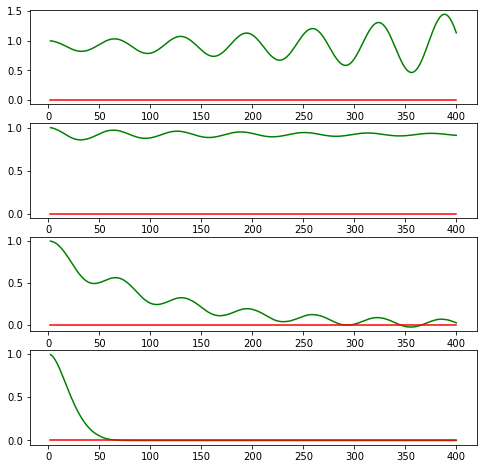

In [36]:
def twiddle(tol, p, dp, s): 

    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p,speed=s)

    it = 0
    while sum(dp) > tol:
        print("Iter {}, berror = {}, params={}".format(it, best_err, p))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p,speed=s)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p,speed=s)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return it,p,best_err




# Auto-tunning:
# Decide initial p value, the script spit out optimized p,i,d gain.
# Note the 2nd argument of tupple is speed for our kinematic model.

#p, s = [0.3, 0, 0], 2
p, s = [0.19, 0, 0], 2 


# optimize p with others fixed.
# optimized p is a real initial p value.
dp = [1, 0, 0]
tol = 0.2
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_traj1, y_traj1, err = run(robot, params, speed=s)
init_p = params[0]

# optimize d with others fixed.
# optimized d is a real initial d value.
p = [init_p, 0, 0]
dp = [0, 1, 0]
tol = 0.2
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_traj2, y_traj2, err = run(robot, params, speed=s)
init_d = params[1]

# optimize i with others fixed.
# optimized i is a real initial i value.
p = [init_p, init_d, 0]
dp = [0, 0, 1]
tol = 0.002
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_traj3, y_traj3, err = run(robot, params, speed=s)
init_i = params[2]

# optimize p,i,d together with 3 initial values
# optimized p is a real initial p value.
#Coordinate ascent local search to optimize P,D,I together
p = [init_p, init_d, init_i]
dp = [1, 1, 1]
tol = 0.002
it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_traj4, y_traj4, err = run(robot, params, speed=s)


n = len(x_traj1)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 8))
ax1.plot(x_traj1, y_traj1, 'g', label='Twiddle PID controller')
ax1.plot(x_traj1, np.zeros(n), 'r', label='reference')
ax2.plot(x_traj2, y_traj2, 'g', label='Twiddle PID controller')
ax2.plot(x_traj2, np.zeros(n), 'r', label='reference')
ax3.plot(x_traj3, y_traj3, 'g', label='Twiddle PID controller')
ax3.plot(x_traj3, np.zeros(n), 'r', label='reference')
ax4.plot(x_traj4, y_traj4, 'g', label='Twiddle PID controller')
ax4.plot(x_traj4, np.zeros(n), 'r', label='reference')

## Further auto-tunning at different speed

In auto-tunning script, i choose the PID setting at the value of speed to 2. The reason was partly because the delta time that the websocket messages arrive in our C++ function is greater than 20msec(our simulator cycle). Remember from the previous path-planning project that our simulator cycle is 20msec(0.02 sec) and we were tossed back from the simulator around 50~70% left-over moves that were not eaten by our simulator among our 50 moves long path. Term 2 simulator was taking not that long but was guessed to be more than 40msec. So, i assumed 80msec, right or wrong. And this means i could enforce my desired speed in around 80msec interval, 12 moves per second. And since our desired speed was 50mph(25m/sec, 0.5m per move), the speed here was set 2m per move to achieve the same 50mph in 12 moves.

Another reason is that the PID setting at the value of speed 2 showed less loss on a curve trajectory as shown below(although it showed worse loss on a line trajectory). With PID setting saught at the speed 2, the Final Error on the curve trajectory was 0.0019844024671733206), which was less than the one at the speed 1(0.01354226400752002). The figues below show the comparison between PID setting with speed 1 and 2 in our auto-tunning, and the the speed setting 2 showed better stability on a curve trajectory at 50mph in our simulation.

### **Auto-tunning for curv at speed 1**
Note that we started searching at position [0.15910442248556678, 1.587110426670305, 0.005533208544239475] and after many iteration it coverged to [0.20877822643745259, 3.0511517488783064, 0.005540710267815578], which is the local optima we obtained above at speed 1.

Iter 0, berror = 6.292135273676781e-10, params=[0.3083945237000776, 3.73066396507075, 0.009287418277686622]
Iter 1, berror = 6.292135273676781e-10, params=[0.3083945237000776, 3.7306639650707503, 0.009287418277686532]
Iter 2, berror = 6.292135273676781e-10, params=[0.3083945237000777, 3.7306639650707507, 0.009287418277686532]
Iter 3, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.7306639650707507, 0.009287418277686532]
Iter 4, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.730663965070751, 0.009287418277686532]
Iter 5, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.730663965070751, 0.009287418277686532]
Iter 6, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.730663965070751, 0.009287418277686532]
Iter 7, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.730663965070751, 0.009287418277686532]
Iter 8, berror = 6.292135273676781e-10, params=[0.3083945237000778, 3.730663965070751, 0.009287418277686532]
Iter 9, berror = 

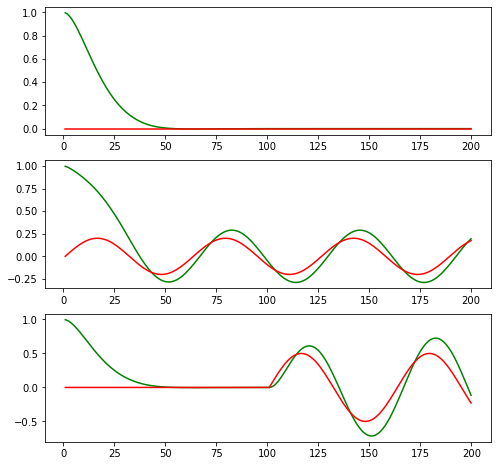

In [29]:
def run_curv(robot, params, y, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        #cte = robot.y
        #cte = y[i]-robot.y
        cte = robot.y-y[i]
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

def twiddle_curv(tol, y, p, dp, s): 
    
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run_curv(robot, p,y, speed=s)

    # TODO: twiddle loop here
    it = 0
    while sum(dp) > tol:
        print("Iter {}, berror = {}, params={}".format(it, best_err, p))
        for i in range(3):
            p[i]+=dp[i] #try going uphill
            robot = make_robot()
            _,_,err = run_curv(robot, p,y, speed=s)
            if err < best_err: #error reduced?
                best_err = err #if succeed, keep it
                dp[i] *= 1.1   #inc d
            else:
                p[i] -= 2*dp[i] #if no, go opp. way
                robot = make_robot()
                _,_,err = run_curv(robot, p,y, speed=s)
                
                if err < best_err:#error reduced?
                    best_err = err
                    dp[i] *=1.1
                else:
                    p[i]+= dp[i] #if either way is not good, reduce scale.
                    dp[i] *= 0.9
        it+=1
    return it,p, best_err


#for speed =1
#p, s = [0.15910442248556678, 1.587110426670305, 0.005533208544239475], 1 
p, s = [0.3083945237000776, 3.73066396507075, 0.009287418277686622],1

dp = [1, 1, 1]
tol = 0.002



it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params, speed=s)
init_p = params[0]

y_curv = 1/5*np.sin(1/10*np.arange(200))
it,params_curv, err = twiddle_curv(tol,y_curv, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_curv))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory2, y_trajectory2, err = run_curv(robot, params_curv, y_curv, speed=s)

y_comb = np.concatenate((np.zeros(100),1/2*np.sin(1/10*np.arange(100))), axis=0)
it,params_comb, err = twiddle_curv(tol,y_comb, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_comb))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory3, y_trajectory3, err = run_curv(robot, params_comb, y=y_comb, speed=s)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax2.plot(x_trajectory2, y_trajectory2, 'g', label='Twiddle PID controller')
ax2.plot(x_trajectory2, y_curv, 'r', label='reference')
ax3.plot(x_trajectory3, y_trajectory3, 'g', label='Twiddle PID controller')
ax3.plot(x_trajectory3, y_comb, 'r', label='reference')

### **auto-tunning for curv at speed 2**
With PID setting saught at the setting of speed 2, the trajectory shows less Final Error(Final error = 0.0019844024671733206) when compared with one at speed 1(0.01354226400752002)

Iter 0, berror = 0.001049538446113687, params=[0.15910442248556678, 1.587110426670305, 0.005533208544239475]
Iter 1, berror = 0.00011203077466821706, params=[0.15910442248556667, 2.5871104266703053, 0.005533208544239443]
Iter 2, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 3, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 4, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 5, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 6, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 7, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239443]
Iter 8, berror = 0.00011203077466821706, params=[0.15910442248556655, 2.5871104266703053, 0.005533208544239

Iter 78, berror = 6.562269287961211e-08, params=[0.21025941333156503, 3.0933951204541272, 0.005533208544239464]
Iter 79, berror = 6.407317176802417e-08, params=[0.21025941333156506, 3.0710994979743975, 0.005533208544239463]
Iter 80, berror = 4.101289396686024e-08, params=[0.2092703833074347, 3.071099497974397, 0.005533208544239464]
Iter 81, berror = 4.101289396686024e-08, params=[0.2092703833074347, 3.071099497974397, 0.005533208544239465]
Iter 82, berror = 4.101289396686024e-08, params=[0.2092703833074347, 3.0710994979743975, 0.005533208544239464]
Iter 83, berror = 4.101289396686024e-08, params=[0.20927038330743472, 3.0710994979743975, 0.005533208544239464]
Iter 84, berror = 3.6848856228954007e-08, params=[0.21006348648378487, 3.071099497974397, 0.005533208544239464]
Iter 85, berror = 3.6848856228954007e-08, params=[0.21006348648378487, 3.0710994979743975, 0.005533208544239465]
Iter 86, berror = 3.089695670931326e-08, params=[0.21006348648378487, 3.0841331866712722, 0.0055332085442394

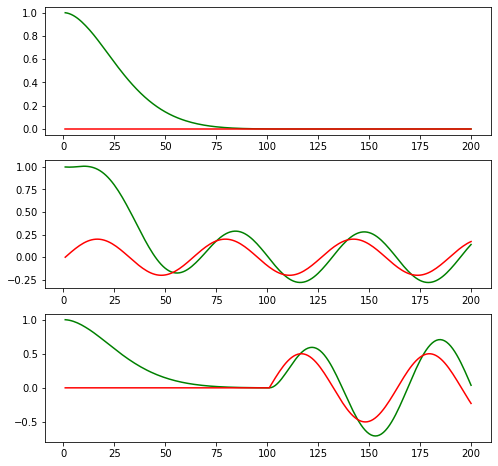

In [30]:
def run_curv(robot, params, y, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        #cte = robot.y
        #cte = y[i]-robot.y
        cte = robot.y-y[i]
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

def twiddle_curv(tol, y, p, dp, s): 
    
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run_curv(robot, p,y, speed=s)
    # TODO: twiddle loop here
    it = 0
    while sum(dp) > tol:
        for i in range(3):
            p[i]+=dp[i] #try going uphill
            robot = make_robot()
            _,_,err = run_curv(robot, p,y, speed=s)
            if err < best_err: #error reduced?
                best_err = err #if succeed, keep it
                dp[i] *= 1.1   #inc d
            else:
                p[i] -= 2*dp[i] #if no, go opp. way
                robot = make_robot()
                _,_,err = run_curv(robot, p,y, speed=s)
                
                if err < best_err:#error reduced?
                    best_err = err
                    dp[i] *=1.1
                else:
                    p[i]+= dp[i] #if either way is not good, reduce scale.
                    dp[i] *= 0.9
        it+=1
    return it,p, best_err


#for speed =2
p, s = [0.15910442248556678, 1.587110426670305, 0.005533208544239475], 1 #for speed =2
#p, s = [0.15910442248556678, 1.587110426670305, 0.005533208544239475], 2 #for speed =2
#p, s = [0.15910442248556678, 1.587110426670305, 0.005533208544239475], 1 
#p, s = [0.3083945237000776, 3.73066396507075, 0.009287418277686622],2

dp = [1, 1, 1]
tol = 0.002


it,params, err = twiddle(tol, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params, speed=s)


y_curv = 1/5*np.sin(1/10*np.arange(200))
it,params_curv, err = twiddle_curv(tol,y_curv, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_curv))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory2, y_trajectory2, err = run_curv(robot, params_curv, y_curv, speed=s)

y_comb = np.concatenate((np.zeros(100),1/2*np.sin(1/10*np.arange(100))), axis=0)
it,params_comb, err = twiddle_curv(tol,y_comb, p, dp, s)
print("iter{} Final error = {}, params={}".format(it,err, params_comb))
print("let's run PID with learned parameter")
robot = make_robot()
x_trajectory3, y_trajectory3, err = run_curv(robot, params_comb, y=y_comb, speed=s)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
ax2.plot(x_trajectory2, y_trajectory2, 'g', label='Twiddle PID controller')
ax2.plot(x_trajectory2, y_curv, 'r', label='reference')
ax3.plot(x_trajectory3, y_trajectory3, 'g', label='Twiddle PID controller')
ax3.plot(x_trajectory3, y_comb, 'r', label='reference')